# The TESS full-frame images lightcurve of nova V606 Vul extracted using LightKurve package

This notebook is created to address the referee's comments on the paper "TESS photometry of the nova eruption in V606 Vul: asymmetric photosphere and multiple ejections?" ([arXiv e-print](https://arxiv.org/abs/2311.04903)) submitted to ApJ. While we direct readers to the paper for the final period analysis, this notebook reproduces the main claim: the presence of a ~0.1277 day period in the nova light curve near its peak brightness, using only the standard TESS data analysis package [LightKurve](https://github.com/lightkurve/lightkurve).

The eruption of V606 Vul was happening during the TESS Sector 41 and we start with the analysis of the eruption lightcurve. The same analysis is then applied to the two pre-eruption and three post-eruption TESS sectors covering the nova position to reveal that these sectors contain no useful data as the nova is too faint for TESS outside Sector 41.

We then produce Sector 41 lightcurves for two check stars 4 and 10 arcminutes from the nova to make sure the 0.1277 day modulation found in the nova lightcurve is not present in other sources.

For each source we also extract and analyze the associated off-source (background-only) lightcurve. The Sector 41 background lightcurves are affected by a 0.333 day modulation found consistently for the source and check stars. However, this modulaiton is not detectable in the background-subtracted lightcurves of the nova and check stars.

In [1]:
# Import the packages needed for the analysis
import os
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/kirill/.conda/envs/lk/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/kirill/.lightkurve/cache. Please move all the files in the legacy directory /home/kirill/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
def simple_detrend_and_period_search(lc, period_range=(0.05, 3.0), titleprefixstring=""):
    """
    Process a LightCurve: clip outliers, detrend, and perform Lomb-Scargle period search.

    Parameters:
    lc (LightCurve): The LightCurve object to process.
    period_range (tuple): The range of periods (in days) to search for periods, default is (0.05, 3.0).
    titleprefixstring (str): A prefix string for titles in the generated plots.

    Returns:
    float: The best period detected by the Lomb-Scargle periodogram.

    Workflow:
    1. Clip Outliers (3-sigma): Removes significant outliers from the lightcurve to clean the data.
    2. Detrend the LightCurve: Uses a 5th-degree polynomial to remove long-term trends.
    3. Re-clip After Detrending: Removes outliers after detrending.
    4. Lomb-Scargle Period Analysis:
       - Converts the specified period range into frequency range.
       - Computes the Lomb-Scargle periodogram.
       - Identifies the best period (highest power).
    5. Generate Plots:
       - Display the sigma-clipped lightcurve.
       - Display the detrended lightcurve.
       - Display the sigma-clipped lightcurve after detrending.
       - Plot the Lomb-Scargle periodogram as a function of frequency, highlighting the best period.
   
    """
    # Step 1: Clip the lightcurve at 3-sigma
    clipped_lc = lc.remove_outliers(sigma=3)
    clipped_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped")
    plt.show()

    # Step 2: Detrend the lightcurve using using scipy's Savitzky-Golay filter wrapped in lc.flatten()
    detrended_lc = clipped_lc.flatten(window_length=101, polyorder=5)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended")
    plt.show()
    
    # Step 2.5: Clip the lightcurve again (to remove mini-flares in nova V606 Vul lightcurve)
    detrended_lc = detrended_lc.remove_outliers(sigma=3)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended, sigma-clipped")
    plt.show()    

    # Step 3: Perform Lomb-Scargle periodogram analysis using LightKurve's built-in functionality
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period

    # Create the periodogram
    periodogram = detrended_lc.to_periodogram(method="lombscargle", 
                                              minimum_frequency=min_frequency, 
                                              maximum_frequency=max_frequency)

    # Find and print the best period
    best_period = periodogram.period_at_max_power
    print(f"The best period is: {best_period:.4f} days")

    # Step 4: Plot the periodogram as a function of frequency
    plt.figure(figsize=(10, 5))
    plt.plot(periodogram.frequency.value, periodogram.power, label="Lomb-Scargle Power")
    plt.axvline(x=1/best_period.value, color="red", linestyle="--", label=f"Best Period = {best_period:.4f} days")
    plt.xlabel("Frequency (1/day)")
    plt.ylabel("Power")
    plt.title(f"{titleprefixstring} Lomb-Scargle Periodogram")
    plt.legend()
    plt.grid()
    plt.show()

    return best_period.value


In [3]:
def extract_tess_lightcurve_signle_pix_no_bkg(tpf_cutout, target_source_name, notebook_name="v606_vul_lk_square_aperture"):
    """
    Process TESS lightcurve data from a TPF cutout and save various plots and CSV files in a dedicated directory.

    Parameters:
    tpf_cutout: TargetPixelFile
        The TPF cutout object containing the data.
    target_source_name: str
        The name of the target source.
    notebook_name: str
        The name of the Jupyter notebook (used to name the output directory).
    """
    # Create output directory
    output_dir = notebook_name.lower().replace(" ", "_")
    os.makedirs(output_dir, exist_ok=True)

    # Define and plot the source aperture mask
    custom_mask = np.zeros((tpf_cutout[0].shape[1:]), dtype='bool')
    custom_mask[5:6, 5:6] = True  # custom mask coordinates

    # Define file names
    target_source_name_lowercase_for_filename = target_source_name.lower().replace(" ", "_")
    sector_name_lowercase_for_filename = f"sector{tpf_cutout.sector}"

    # Plot the source aperture
    tpf_cutout.plot(aperture_mask=custom_mask)
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, source aperture")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.eps"), format="eps")

    # Extract and save the raw source lightcurve
    uncorrected_lc = tpf_cutout.to_lightcurve(aperture_mask=custom_mask)
    uncorrected_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, raw lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_plot.png"), format="png", dpi=300)
    uncorrected_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw.csv"), overwrite=True)

    # Create and display the background aperture
    #background_mask = ~tpf_cutout.create_threshold_mask(threshold=0.001, reference_pixel=None) * ~custom_mask
    #tpf_cutout.plot(aperture_mask=background_mask, mask_color='w')
    #plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background aperture")
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.png"), format="png", dpi=300)
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.eps"), format="eps")

    # Extract background lightcurve
    #n_target_pixels = custom_mask.sum()
    #n_background_pixels = background_mask.sum()
    #background_lc_per_pixel = tpf_cutout.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    #background_estimate_lc = background_lc_per_pixel * n_target_pixels

    # Compute the background-subtracted lightcurve
    #bkg_subtracted_lc = uncorrected_lc - background_estimate_lc.flux
    #bkg_subtracted_lc.plot(lw=2, marker='.', linestyle='None')
    #plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background-subtracted lightcurve")
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub_plot.png"), format="png", dpi=300)
    #bkg_subtracted_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub.csv"), overwrite=True)

    # Plot and save the background lightcurve
    #background_estimate_lc.plot(lw=2, marker='.', linestyle='None')
    #plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background lightcurve")
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_plot.png"), format="png", dpi=300)
    #background_estimate_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck.csv"), overwrite=True)

    # Plot raw, background-subtracted, and background-only lightcurves together
    ax = uncorrected_lc.plot(label="Raw", lw=2, marker='.', linestyle='None')
    #bkg_subtracted_lc.plot(ax=ax, label="Background-subtracted", lw=2, marker='.', linestyle='None')
    #background_estimate_lc.plot(ax=ax, label="Background", lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.png"), dpi=300)
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.eps"), format="eps")

    # Run the simplified period analysis
    #print("The simplified period analysis for the background-subtracted source lightcurve")
    #simple_detrend_and_period_search(bkg_subtracted_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} bkg.-sub.:")
    #print("The simplified period analysis for the background lightcurve")
    #simple_detrend_and_period_search(background_estimate_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} background:")
    print("The simplified period analysis for the raw single-pixel lightcurve")
    simple_detrend_and_period_search(uncorrected_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} bkg.-sub.:")


In [4]:
def extract_tess_lightcurve(tpf_cutout, target_source_name, notebook_name="v606_vul_lk_square_aperture"):
    """
    Process TESS lightcurve data from a TPF cutout and save various plots and CSV files in a dedicated directory.

    Parameters:
    tpf_cutout: TargetPixelFile
        The TPF cutout object containing the data.
    target_source_name: str
        The name of the target source.
    notebook_name: str
        The name of the Jupyter notebook (used to name the output directory).
    """
    # Create output directory
    output_dir = notebook_name.lower().replace(" ", "_")
    os.makedirs(output_dir, exist_ok=True)

    # Define and plot the source aperture mask
    custom_mask = np.zeros((tpf_cutout[0].shape[1:]), dtype='bool')
    custom_mask[5:6, 5:6] = True  # custom mask coordinates

    # Define file names
    target_source_name_lowercase_for_filename = target_source_name.lower().replace(" ", "_")
    sector_name_lowercase_for_filename = f"sector{tpf_cutout.sector}"

    # Plot the source aperture
    tpf_cutout.plot(aperture_mask=custom_mask)
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, source aperture")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.eps"), format="eps")

    # Extract and save the raw source lightcurve
    uncorrected_lc = tpf_cutout.to_lightcurve(aperture_mask=custom_mask)
    uncorrected_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, raw lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_plot.png"), format="png", dpi=300)
    uncorrected_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw.csv"), overwrite=True)

    # Create and display the background aperture
    background_mask = ~tpf_cutout.create_threshold_mask(threshold=0.001, reference_pixel=None) * ~custom_mask
    tpf_cutout.plot(aperture_mask=background_mask, mask_color='w')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background aperture")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.eps"), format="eps")

    # Extract background lightcurve
    n_target_pixels = custom_mask.sum()
    n_background_pixels = background_mask.sum()
    background_lc_per_pixel = tpf_cutout.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    background_estimate_lc = background_lc_per_pixel * n_target_pixels

    # Compute the background-subtracted lightcurve
    bkg_subtracted_lc = uncorrected_lc - background_estimate_lc.flux
    bkg_subtracted_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background-subtracted lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub_plot.png"), format="png", dpi=300)
    bkg_subtracted_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub.csv"), overwrite=True)

    # Plot and save the background lightcurve
    background_estimate_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_plot.png"), format="png", dpi=300)
    background_estimate_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck.csv"), overwrite=True)

    # Plot raw, background-subtracted, and background-only lightcurves together
    ax = uncorrected_lc.plot(label="Raw", lw=2, marker='.', linestyle='None')
    bkg_subtracted_lc.plot(ax=ax, label="Background-subtracted", lw=2, marker='.', linestyle='None')
    background_estimate_lc.plot(ax=ax, label="Background", lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.png"), dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.eps"), format="eps")

    # Run the simplified period analysis
    print("The simplified period analysis for the background-subtracted source lightcurve")
    simple_detrend_and_period_search(bkg_subtracted_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} bkg.-sub.:")
    print("The simplified period analysis for the background lightcurve")
    simple_detrend_and_period_search(background_estimate_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} background:")


## V606 Vul

The target is V606 Vul = Nova Vulpeculae 2021 = TCP J20210770+2914093
The analysis was initially performed with the Nova position measured with the SAI 0.6-m telescope (reported at TOCP http://www.cbat.eps.harvard.edu/unconf/followups/J20210770+2914093.html ):
 20:21:07.703 +29:14:09.25 305.2820958 +29.2359028
The analysis was later re-done using Gaia DR3 position of the likely nova host: 
 20:21:07.7044  +29:14:09.091 305.2821017 +29.2358586
This makes no difference at the TESS image scale of 20"/pix.

In [5]:
# Set target source name and position, search for TESS data
target_source_name="V606 Vul"
# V606 Vul - measured posiiton of the nova (SAI 0.6m telescope)
#search_lc = lk.search_tesscut("20:21:07.703 +29:14:09.25")
# Gaia DR3 position of the counterpart
search_lc = lk.search_tesscut("20:21:07.7044  +29:14:09.091")
search_lc

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,TESScut,1426,20:21:07.7044 +29:14:09.091,0.0
1,TESS Sector 15,2019,TESScut,1426,20:21:07.7044 +29:14:09.091,0.0
2,TESS Sector 41,2021,TESScut,475,20:21:07.7044 +29:14:09.091,0.0
3,TESS Sector 55,2022,TESScut,475,20:21:07.7044 +29:14:09.091,0.0
4,TESS Sector 81,2024,TESScut,158,20:21:07.7044 +29:14:09.091,0.0
5,TESS Sector 82,2024,TESScut,158,20:21:07.7044 +29:14:09.091,0.0


### Sector 41 - the eruption

A period of 0.1279 days was found in the light curve after applying detrending and sigma-clipping. While the paper's analysis relied on manually selecting time intervals where the modulation was clearly visible and setting break points for piecewise linear trend fitting, we use a simplified approach here. This approach employs detrending and clipping functions available in LightKurve, making them easier to implement in a Jupyter notebook. The simplified method demonstrates that the periodic modulation's presence is robust and does not depend strongly on the specific detrending algorithm or time interval selection.

The same detrending and clipping procedure is then applied to the background-only (off-source) lightcurve. The background shows modulation with a period of 0.3334 days, possibly due to a presencs of a variable star within the backgroudn extraction region. The background lightcurve periodogram shows no peaks around the period of 0.1279 days found in the nova lightcurve.

The simplified period analysis for the raw single-pixel lightcurve


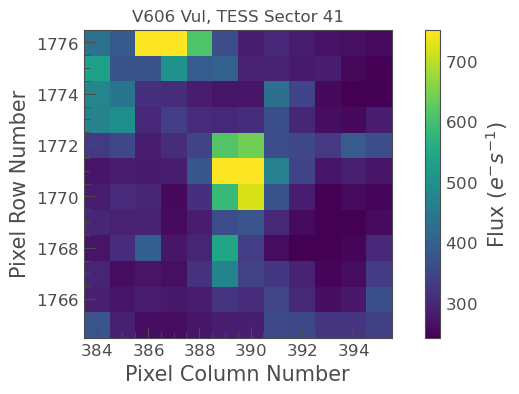

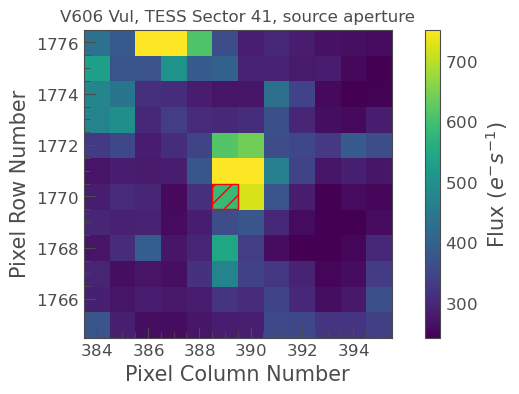

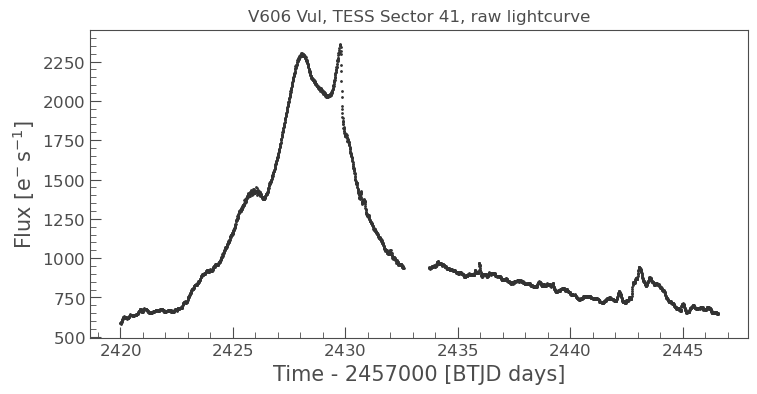

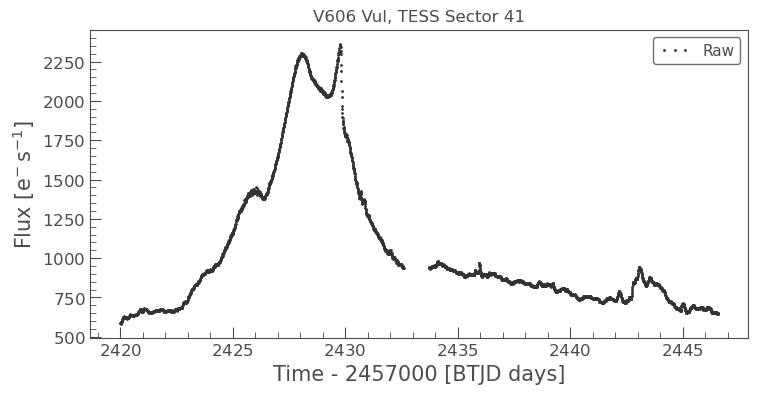

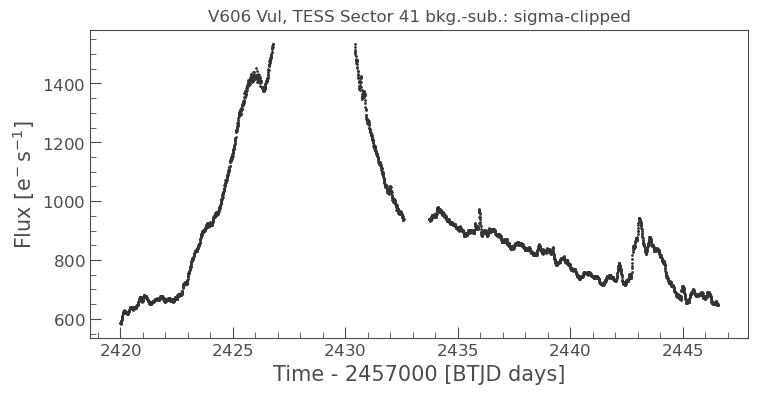

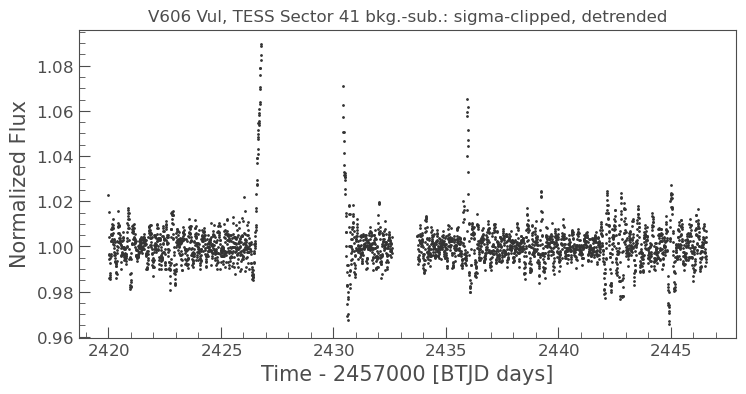

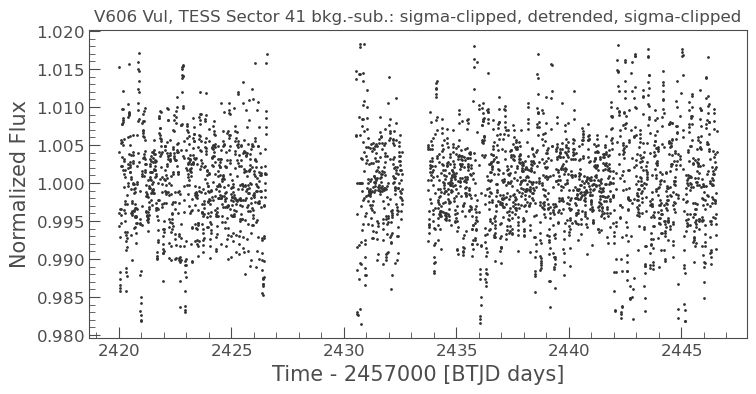

The best period is: 0.1278 d days


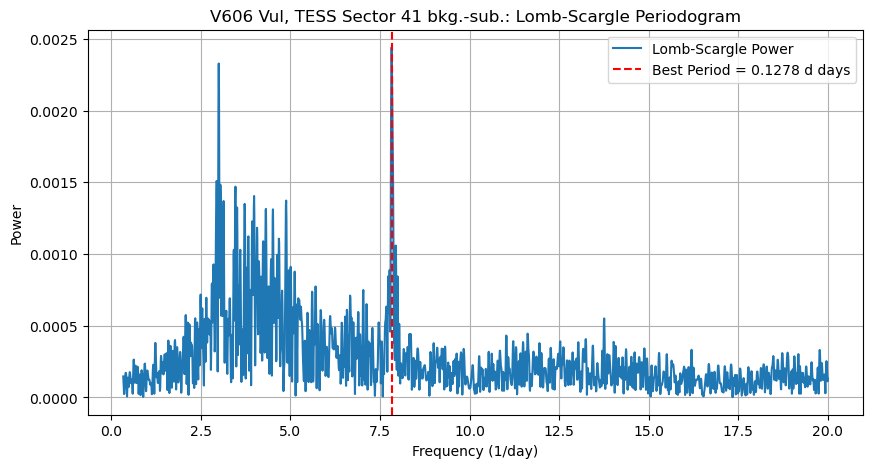

In [6]:
# Download and plot the TESS FFI cutout centered on the source
tpf_cutout = search_lc[2].download(cutout_size=12, quality_bitmask='hard')
tpf_cutout.plot();
# Add the TESS sector name as the title
plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")

# Extract the lightcurves and make plots
extract_tess_lightcurve_signle_pix_no_bkg(tpf_cutout, target_source_name)

In [7]:
lk.show_citation_instructions()